<a href="https://colab.research.google.com/github/VarvaraFad/Regression_Classification_Models/blob/main/Copy_Regression_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Регрессия

С 1ого октября отменяется НДС на бриллианты, теперь они становятся новым инвестиционным инструментом. Давайте сделаем модель ценообразования для них.

Скачаем датасет diamonds.csv

В нем представлены характеристики бриллиантов и их цены с сайта jamesallen (B2C площадка) с 2022-07-01

**Описание полей**


* fluor - флуорисценуия (свойство камня светиться в лучах ультр)
* symmetry - показатель симметричности
* platform - название платформы, где был размещен камень
* quality_group - составной показатель из cut polish symmetry
* size_group - каратно весовая группа
* big_size_group - каратно-весовая группа
* shape - форма
* color - цвет
* clarity - чистота
* cut - качество огранки (может быть только у круглых камней)
* polish - полировка
* id - номер камня
* date - дата
* price - цена
* carat - кол-во карат
* tablepercent - размер площадки по отношению ширине
* price_per_carat - цена за карат
* z - длина (diameter)
* x - ширина
* depth_perc - отношение высоты к ширине
* y - высота



In [ ]:
import pandas as pd
import numpy as np
# Импортируем библиотеки для отрисовки
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = 'drive/MyDrive/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Профильный модуль/ДЗ2/diamonds.csv', index_col=0)

Необходимо предсказать `price_per_carat`

In [ ]:
df.head()

,fluor,symmetry,platform,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y
135269,NONE,EX,jamesallen,PS,F,SI1,NaN,EX,13870838,202206,12850.0,1.55,8290.32,10.29,6.41,62.0,3.97420
48477,MED,EX,jamesallen,RD,H,VVS2,EX,EX,11725253,202207,7510.0,1.02,7362.75,6.41,6.45,62.5,4.03125
236786,NONE,EX,jamesallen,EM,H,IF,NaN,EX,14444347,202205,21220.0,2.01,10557.21,8.60,6.37,65.0,4.14050
235781,NONE,EX,jamesallen,RD,E,VS2,EX,EX,14438434,202207,8660.0,1.00,8660.00,6.39,6.44,61.4,3.95416
277744,NONE,VG,jamesallen,RD,F,VS1,VG,EX,14615276,202206,8480.0,1.00,8480.00,6.28,6.36,62.3,3.96228


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222222 entries, 135269 to 310690
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fluor            222207 non-null  object 
 1   symmetry         222218 non-null  object 
 2   platform         222218 non-null  object 
 3   shape            222218 non-null  object 
 4   color            222218 non-null  object 
 5   clarity          222218 non-null  object 
 6   cut              148981 non-null  object 
 7   polish           222218 non-null  object 
 8   id               222222 non-null  int64  
 9   date             222222 non-null  int64  
 10  price            222222 non-null  float64
 11  carat            222222 non-null  float64
 12  price_per_carat  222222 non-null  float64
 13  z                222222 non-null  float64
 14  x                222222 non-null  float64
 15  depth_perc       222222 non-null  float64
 16  y                222222 non-null 

Задание 1: Очистка

Не все камни успевают продаться за один месяц, поэтому в таблице есть повторы. Объединим данные по одному камню.

**Попробуем найти аномалии:** вдруг цена на некоторые камни сильно меняется (то есть продавец сам не знает, по какой цене их продавать). Также убедимся, что остальные параметры камня не меняются.

In [ ]:
id_stat = df.groupby(by='id')['carat'].count().to_frame() #Посчитайте статистику по кол-ву камней

# разделите выборку на две части

df_one = df.query('id == @id_stat.query("carat == 1").index.tolist()')  # те камни, которые встречались один раз
df_three = df.query('id == @id_stat.query("carat == 2 or carat == 3").index.tolist()') # те камни, которые встречались 2 или 3 раза

stat = df_three.groupby('id')[['carat','price', 'price_per_carat','x', 'y','z','depth_perc']].agg(np.std) # Посчитайте дстандартное отклонение по нескольким полям,
#  подумайте где оно должно равняться 0, а где меняться в каких-то разумных пределах

# Удалите аномальные наблюдения
df_three = df_three.query('id == @stat.query("y==0 and depth_perc==0").index.tolist()').sort_values(by=['id','date'])

df_three_1 = df_three.groupby('id').agg('last').reset_index() #тепреь в качестве цены возьмем последнее значение по времени

df = pd.concat([df_one, df_three_1]).reset_index(drop=True) # соединяем результаты

In [ ]:
stat

,carat,price,price_per_carat,x,y,z,depth_perc
id,,,,,,,
19423,0.0,334.863156,318.916742,0.0,0.026835,0.0,0.404145
19449,0.0,494.974747,423.054916,0.0,0.000000,0.0,0.000000
19501,0.0,831.384388,415.692194,0.0,0.027436,0.0,0.346410
19504,0.0,0.000000,0.000000,0.0,0.014213,0.0,0.212132
19505,0.0,813.172798,404.564074,0.0,0.028602,0.0,0.353553
...,...,...,...,...,...,...,...
15409696,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
15410303,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
15410668,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [ ]:
df

,fluor,symmetry,platform,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y
0,NONE,EX,jamesallen,PS,D,SI2,NaN,EX,14224443,202205,9120.0,1.51,6039.74,10.67,6.23,59.0,3.67570
1,NONE,VG,jamesallen,EM,K,SI2,NaN,VG,12902293,202205,1390.0,0.91,1527.47,6.30,4.58,71.0,3.25180
2,NONE,VG,jamesallen,PS,J,VS1,NaN,VG,12771762,202207,15990.0,2.27,7044.05,11.66,7.26,62.2,4.51572
3,MED,EX,jamesallen,RD,J,SI2,EX,EX,14584509,202205,3700.0,1.01,3663.37,6.37,6.42,62.0,3.98040
4,NONE,EX,jamesallen,RD,G,SI1,EX,EX,14773748,202206,7170.0,1.00,7170.00,6.30,6.35,63.7,4.04495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131619,NONE,EX,jamesallen,RD,I,SI1,EX,EX,15409696,202207,6040.0,1.01,5980.20,6.46,6.49,60.8,3.94592
131620,MED,EX,jamesallen,OV,H,VVS2,None,EX,15410303,202207,6620.0,1.01,6554.46,7.76,5.40,65.0,3.51000
131621,NONE,VG,jamesallen,EM,D,VS1,None,EX,15410668,202207,14750.0,1.50,9833.33,7.84,5.43,65.8,3.57294
131622,MED,EX,jamesallen,EM,H,SI2,None,EX,15410717,202207,48230.0,4.53,10646.80,11.61,7.57,67.5,5.10975


In [ ]:
stat

,carat,price,price_per_carat,x,y,z,depth_perc
id,,,,,,,
19423,0.0,334.863156,318.916742,0.0,0.026835,0.0,0.404145
19449,0.0,494.974747,423.054916,0.0,0.000000,0.0,0.000000
19501,0.0,831.384388,415.692194,0.0,0.027436,0.0,0.346410
19504,0.0,0.000000,0.000000,0.0,0.014213,0.0,0.212132
19505,0.0,813.172798,404.564074,0.0,0.028602,0.0,0.353553
...,...,...,...,...,...,...,...
15409696,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
15410303,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
15410668,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Цены на бриллианты достаточно сильно меняются, попробуем вычислить коэффициент инфляции и приведем цены к последнему месяцу. Стоит учесть, что цены на все бриллианты не изменяются синхронно, то есть изменение в определенных группах может быть разным.

*Определм эти группы и рассчитаем коэффициенты инфляции для каждой из них. Подправим цены на эти коэффициенты и создадим новую переменную.*

In [ ]:
categories = ['carat'] #определите по каким группам отпределять инфляцию (к примеру можно добавить каратную группу)

df_index = df.groupby(['date'] + categories)[['price_per_carat']]\
             .mean()\
             .reset_index() # индекс цен

date_max = df_index.date.max()


df_index = df_index.merge(df_index.query('date == @date_max')[categories + ['price_per_carat']]\
                          .rename(columns={'price_per_carat': 'price_per_carat_max'}),
                          on=categories, how='outer') # сопоставляем группы с максимальной датой

df_index['inflation'] = df_index['price_per_carat_max'] / df_index.price_per_carat # вычисляем инфляцию

df_with_inf = df.merge(df_index[['date'] + categories + ['inflation']],
                        on=['date'] + categories, how='left') # соединяем все в одной таблице

In [ ]:
df_with_inf

,fluor,symmetry,platform,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y,inflation
0,NONE,EX,jamesallen,PS,D,SI2,NaN,EX,14224443,202205,9120.0,1.51,6039.74,10.67,6.23,59.0,3.67570,1.048595
1,NONE,VG,jamesallen,EM,K,SI2,NaN,VG,12902293,202205,1390.0,0.91,1527.47,6.30,4.58,71.0,3.25180,1.058412
2,NONE,VG,jamesallen,PS,J,VS1,NaN,VG,12771762,202207,15990.0,2.27,7044.05,11.66,7.26,62.2,4.51572,1.000000
3,MED,EX,jamesallen,RD,J,SI2,EX,EX,14584509,202205,3700.0,1.01,3663.37,6.37,6.42,62.0,3.98040,1.066096
4,NONE,EX,jamesallen,RD,G,SI1,EX,EX,14773748,202206,7170.0,1.00,7170.00,6.30,6.35,63.7,4.04495,1.051478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131619,NONE,EX,jamesallen,RD,I,SI1,EX,EX,15409696,202207,6040.0,1.01,5980.20,6.46,6.49,60.8,3.94592,1.000000
131620,MED,EX,jamesallen,OV,H,VVS2,None,EX,15410303,202207,6620.0,1.01,6554.46,7.76,5.40,65.0,3.51000,1.000000
131621,NONE,VG,jamesallen,EM,D,VS1,None,EX,15410668,202207,14750.0,1.50,9833.33,7.84,5.43,65.8,3.57294,1.000000
131622,MED,EX,jamesallen,EM,H,SI2,None,EX,15410717,202207,48230.0,4.53,10646.80,11.61,7.57,67.5,5.10975,1.000000


### Задание 2: Модель

Определим функцию потерь (MSE или MAE) и аргументируем выбор.
Попробуем сделать baseline.
Используем LableEncoder для категориальных фичей и **построем линейную модель**.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:
#Label Encoding

le = preprocessing.LabelEncoder()
df_encoded = df.apply(le.fit_transform)

In [ ]:
df_encoded

,fluor,symmetry,platform,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y
0,2,0,0,7,0,4,4,0,44408,0,800,70,11781,580,218,113,9305
1,2,3,0,1,7,4,4,2,16893,0,27,10,53,143,53,235,3154
2,2,3,0,7,6,5,4,2,15927,2,1487,146,15173,679,321,145,21649
3,1,0,0,9,6,4,0,0,65487,0,258,20,3976,150,237,143,14701
4,2,0,0,9,3,3,0,0,79933,1,605,19,15598,143,230,161,15870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131619,2,0,0,9,5,3,0,0,131531,2,492,20,11601,159,244,131,14056
131620,1,0,0,5,4,8,3,0,131565,2,550,20,13501,289,135,174,6957
131621,2,3,0,1,0,5,3,0,131571,2,1363,69,24015,297,138,183,7880
131622,1,0,0,1,4,4,3,0,131578,2,4462,363,26305,674,352,200,27465


In [ ]:
#Разделим данные
X = df_encoded.drop(columns=["price_per_carat"])
y = df_encoded["price_per_carat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
# Отмасштабируем наши признаки
# Создадим объект класса StandardScaler

scaler = StandardScaler()

# Сделаем .fit() на обучении
scaler.fit(X_train, y_train) # считает среднее по выборке и std

# .transform() на обучении и тесте (возвращает numpy, поэтому надо самим конвертировать обратно в dataframe с нужными индексами колонками)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [ ]:
# Построим линейную модель
from sklearn.linear_model import LinearRegression

# Содадим объект класса LinearRegressionс параметрами по умолчанию
model_LR = LinearRegression()

# Обучим его на обучающем датасете
model_LR.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Получим предсказания
y_pred_test_LR = model_LR.predict(X_test)


In [ ]:
# Посмотрим на функции потерь
print("MSE (LR):  ", mean_squared_error(y_test, y_pred_test_LR))
print("MAE (LR): ", mean_absolute_error(y_test, y_pred_test_LR)) # Информативнее будет смотреть на данную величину,
                                                                 #поскольку она показывает среднее отклонение от реальной цены
print("MAX_ERROR (LR): ", max_error(y_test, y_pred_test_LR))

MSE (LR):   12606451.630949741
MAE (LR):  2722.15949194445
MAX_ERROR (LR):  22139.050332559942


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Эти функции ошибки реализованы в модуле metrics библиотеки sklearn -- давайте ими воспользуемся
print("R2: ", r2_score(y_test, y_pred_test_LR))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred_test_LR))

R2:  0.869668396820389
MAPE:  0.4951051076122676


Теперь попробуем OHE или TargetEncoder (сравним их).

Нормализируем данные.

Поработаем с пропусками (обратим внимание на то, что у fluor возможен пропуск значения, а возможно отсутствие флуоресценции)

Посмотрим, насколько получилось улучшить результат.

In [ ]:
! pip install category_encoders

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

from typing import Tuple, List


def OHE(df: pd.DataFrame, columns: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    """
    Вместо это функции можно использовать и функционал pandas
    """
    index = df.index
    one = OneHotEncoder(sparse=False, categories='auto')
    ohe = one.fit_transform(df[columns])
    col_names = one.get_feature_names(input_features = columns)
    df = df.drop(columns, axis=1)
    df = df.reset_index(drop=True)
    df = pd.concat([df, pd.DataFrame(ohe, columns=col_names)], axis = 1)
    df = df.set_index(index)
    return (df, col_names)

scaler = StandardScaler() # Помните, что на тесте делаем только transform

In [ ]:
categ = df.select_dtypes(include='object').describe().T.index.values
categ

array(['fluor', 'symmetry', 'platform', 'shape', 'color', 'clarity',
       'cut', 'polish'], dtype=object)

In [ ]:
#Применим OHE, колонку с fluor не будем учитывать для предсказаний, поскольку непонятна

df_OHE = pd.get_dummies(
    df,
    columns=['symmetry', 'platform', 'shape', 'color', 'clarity',
       'cut', 'polish'],
    drop_first=True
)

df_OHE

,fluor,id,date,price,carat,price_per_carat,z,x,depth_perc,y,...,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,cut_G,cut_VG,polish_G,polish_VG
0,NONE,14224443,202205,9120.0,1.51,6039.74,10.67,6.23,59.0,3.67570,...,0,1,0,0,0,0,0,0,0,0
1,NONE,12902293,202205,1390.0,0.91,1527.47,6.30,4.58,71.0,3.25180,...,0,1,0,0,0,0,0,0,0,1
2,NONE,12771762,202207,15990.0,2.27,7044.05,11.66,7.26,62.2,4.51572,...,0,0,1,0,0,0,0,0,0,1
3,MED,14584509,202205,3700.0,1.01,3663.37,6.37,6.42,62.0,3.98040,...,0,1,0,0,0,0,0,0,0,0
4,NONE,14773748,202206,7170.0,1.00,7170.00,6.30,6.35,63.7,4.04495,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131619,NONE,15409696,202207,6040.0,1.01,5980.20,6.46,6.49,60.8,3.94592,...,1,0,0,0,0,0,0,0,0,0
131620,MED,15410303,202207,6620.0,1.01,6554.46,7.76,5.40,65.0,3.51000,...,0,0,0,0,0,1,0,0,0,0
131621,NONE,15410668,202207,14750.0,1.50,9833.33,7.84,5.43,65.8,3.57294,...,0,0,1,0,0,0,0,0,0,0
131622,MED,15410717,202207,48230.0,4.53,10646.80,11.61,7.57,67.5,5.10975,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
#Разделим данные
X = df_OHE.drop(columns=["price_per_carat",'fluor'])
y = df_OHE["price_per_carat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
# Отмасштабируем наши признаки
# Создадим объект класса StandardScaler

scaler = StandardScaler()

# Сделаем .fit() на обучении
scaler.fit(X_train, y_train) # считает среднее по выборке и std

# .transform() на обучении и тесте (возвращает numpy, поэтому надо самим конвертировать обратно в dataframe с нужными индексами колонками)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [ ]:
# Построим линейную модель
# Содадим объект класса LinearRegressionс параметрами по умолчанию
model_LR = LinearRegression()

# Обучим его на обучающем датасете
model_LR.fit(X_train, y_train)

# Получим предсказания
y_pred_test_LR_OHE = model_LR.predict(X_test)

In [ ]:
# Посмотрим на функции потерь
print("MSE (LR):  ", mean_squared_error(y_test, y_pred_test_LR_OHE))
print("MAE (LR): ", mean_absolute_error(y_test, y_pred_test_LR_OHE)) # Информативнее будет смотреть на данную величину,
                                                                 #поскольку она показывает среднее отклонение от реальной цены
print("MAX_ERROR (LR): ", max_error(y_test,y_pred_test_LR_OHE))

MSE (LR):   1844492.730093971
MAE (LR):  875.8163773613486
MAX_ERROR (LR):  51428.206781497196


In [ ]:
# Эти функции ошибки реализованы в модуле metrics библиотеки sklearn -- давайте ими воспользуемся
print("R2: ", r2_score(y_test, y_pred_test_LR_OHE))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred_test_LR_OHE))

R2:  0.9127454034891378
MAPE:  0.1528424271387598


При использовании OHE кодирования, функция потерь MAE значительно меньше.

Сравним работу выбранной вами линейной модели с KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Создадим экземпляр класса KNeighborsRegressor с числом ближайших соседей (n_neighbors) равным 3
model_knn = KNeighborsRegressor(n_neighbors = 3)

# Обучим модель
model_knn.fit(X_train, y_train)

# Сделаем предсказание на тестовой выборке
y_pred_KNN = model_knn.predict(X_test)


In [ ]:
# Посмотрим на функции потерь
print("MSE (KNN):  ", mean_squared_error(y_test, y_pred_KNN))
print("MAE (KNN): ", mean_absolute_error(y_test, y_pred_KNN)) # Информативнее будет смотреть на данную величину,
                                                                 #поскольку она показывает среднее отклонение от реальной цены
print("MAX_ERROR (KNN): ", max_error(y_test,y_pred_KNN))

MSE (KNN):   1776163.1698039903
MAE (KNN):  755.3161725862615
MAX_ERROR (KNN):  81193.15333333334


In [ ]:
# Эти функции ошибки реализованы в модуле metrics библиотеки sklearn -- давайте ими воспользуемся
print("R2: ", r2_score(y_test, y_pred_KNN))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred_KNN))

R2:  0.9159777654906747
MAPE:  0.11729504101233795


Видно, что по значение функции потерь MAE модель KNN справилась лучше.
Также по значению абсолютной процентной ошибки у KNN-модели наименьшее - 11-12%.

## Классификация

Загрузим датасет bodyPerformance

Описание:

https://www.kaggle.com/datasets/kukuroo3/body-performance-data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = 'drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_body = pd.read_csv('/content/drive/MyDrive/Профильный модуль/ДЗ2/bodyPerformance.csv') #укажите свой путь

In [ ]:
df_body.head(10)

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B
5,36.0,F,165.4,55.40,22.0,64.0,119.0,23.8,21.0,27.0,153.0,B
6,42.0,F,164.5,63.70,32.2,72.0,135.0,22.7,0.8,18.0,146.0,D
7,33.0,M,174.9,77.20,36.9,84.0,137.0,45.9,12.3,42.0,234.0,B
8,54.0,M,166.8,67.50,27.6,85.0,165.0,40.4,18.6,34.0,148.0,C
9,28.0,M,185.0,84.60,14.4,81.0,156.0,57.9,12.1,55.0,213.0,B


In [ ]:
df_body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [ ]:
categ = df_body.select_dtypes(include='object').describe().T.index.values
categ

array(['gender', 'class'], dtype=object)

In [ ]:
# Оставшиеся категориальные признаки закодируем OHE при помощи pd.get_dummies

df_body_OHE = pd.get_dummies(
    df_body,
    columns=df_body.select_dtypes(object).columns,
    drop_first=True
)

df_body_OHE

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_M,class_B,class_C,class_D
0,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,1,0,1,0
1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,1,0,0,0
2,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,1,0,1,0
3,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,1,1,0,0
4,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,1,0,1,0
13389,21.0,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,1,0,0,1
13390,39.0,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,1,0,0,0
13391,64.0,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,0,0,0,1


In [ ]:
# Посмотрим на соотношение классов в нашем датасете
print(f"Всего класса 0 в датастее: {(df_body_OHE['gender_M'] == 0).sum()}, а класса 1: {(df_body_OHE['gender_M'] == 1).sum()}")

Всего класса 0 в датастее: 4926, а класса 1: 8467


### Задание 1: Определение гендера

Построем модель, которая будет определять гендер.

Для этого определим две метрики качества, на которые мы будем смотреть.

После чего преобразуем категориальные переменные и построем модель бинарной классификации на основе линейного классификатора и сравним с KNN.

P.S.: не забудем про нормализацию.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_body_OHE.drop(columns=["gender_M"])
y = df_body_OHE["gender_M"]

X_train_body, X_test_body, y_train_body, y_test_body = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_body, y_train_body)

# .transform() на обучении и тесте (возвращает numpy, поэтому надо самим конвертировать обратно в dataframe с нужными индексами колонками)
X_train_body = pd.DataFrame(scaler.transform(X_train_body), index=X_train_body.index, columns=X_train_body.columns)
X_test_body  = pd.DataFrame(scaler.transform(X_test_body), index=X_test_body.index, columns=X_test_body.columns)

In [ ]:
# Импортируем логистическую регрессию из модуля linear_model библиотеки sklearn
from sklearn.linear_model import LogisticRegression
# Содадим объект класса LogisticRegression с параметрами по умолчанию
model_LR = LogisticRegression()

# Обучим его на обучающем датасете
model_LR.fit(X_train_body, y_train_body)

# Получим предсказания и посмотрим на долю правильных ответов:
y_pred_test_body_LR = model_LR.predict(X_test_body)
y_pred_train_body_LR = model_LR.predict(X_train_body)

print(f"Доля верно угаданных объектов {(y_pred_test_body_LR == y_test_body).sum() / len(y_test_body)}")

Доля верно угаданных объектов 0.9906681597611049


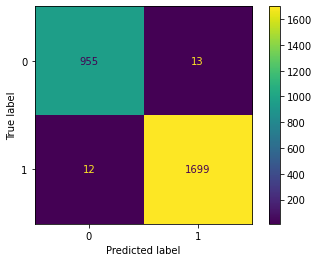

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ConfusionMatrixDisplay.from_predictions(
       y_test_body, y_pred_test_body_LR)

plt.show()

Посмотрим на метрики:

In [ ]:
# метрика Precision
from sklearn.metrics import precision_score

# Посчитаем для нашей модели на обучающем и тестировочном кусках
print(f"TEST:  Precision -- {precision_score(y_test_body, y_pred_test_body_LR)}")
print(f"TRAIN: Precision -- {precision_score(y_train_body, y_pred_train_body_LR)}")

TEST:  Precision -- 0.9924065420560748
TRAIN: Precision -- 0.9890548735394172


In [ ]:
# Roc_auc
from sklearn.metrics import roc_auc_score
y_pred_prob_test_LR = model_LR.predict_proba(X_test_body)[:, 1]
y_pred_prob_train_LR = model_LR.predict_proba(X_train_body)[:, 1]

# Посчитаем для нашей модели на обучающем и тестировочном кусках
print("Logistic Regression")
print(f"TEST:  ROC-AUC -- {roc_auc_score(y_test_body, y_pred_prob_test_LR)}")
print(f"TRAIN: ROC-AUC -- {roc_auc_score(y_train_body, y_pred_prob_train_LR)}")

Logistic Regression
TEST:  ROC-AUC -- 0.9971151663277481
TRAIN: ROC-AUC -- 0.9980579462090253


KNN-модель:

In [ ]:
# Импортируем knn классификатор из модуля neighbors библиотеки sklearn
from sklearn.neighbors import KNeighborsClassifier

# Создадим объект класса KNeighborsClassifier с числом соседей равным 3
model_knn_body = KNeighborsClassifier(3)

# Обучим его на обучающем сете
model_knn_body.fit(X_train_body, y_train_body)

# Получим предсказания для обучающего и тестового датасета
y_pred_train_KNN_body = model_knn_body.predict(X_train_body)
y_pred_test_KNN_body  = model_knn_body.predict(X_test_body)

In [ ]:
# метрика Precision
from sklearn.metrics import precision_score

# Посчитаем для нашей модели на обучающем и тестировочном кусках
print(f"TEST:  Precision -- {precision_score(y_test_body, y_pred_test_KNN_body)}")
print(f"TRAIN: Precision -- {precision_score(y_train_body, y_pred_train_KNN_body)}")

TEST:  Precision -- 0.9882903981264637
TRAIN: Precision -- 0.9946340736324341


In [ ]:
# Для ROC-AUC нам нужны вероятности принадлежности положительному классу
# Для получения вероятностей воспользуемся методом predict_proba и нам нужен второй столбец
y_pred_prob_test_KNN = model_knn_body.predict_proba(X_test_body)[:, 1]
y_pred_prob_train_KNN = model_knn_body.predict_proba(X_train_body)[:, 1]

print("kNN")
print(f"TEST:  ROC-AUC -- {roc_auc_score(y_test_body, y_pred_prob_test_KNN)}")
print(f"TRAIN: ROC-AUC -- {roc_auc_score(y_train_body, y_pred_prob_train_KNN)}")

kNN
TEST:  ROC-AUC -- 0.9952715414599747
TRAIN: ROC-AUC -- 0.9997172053153733


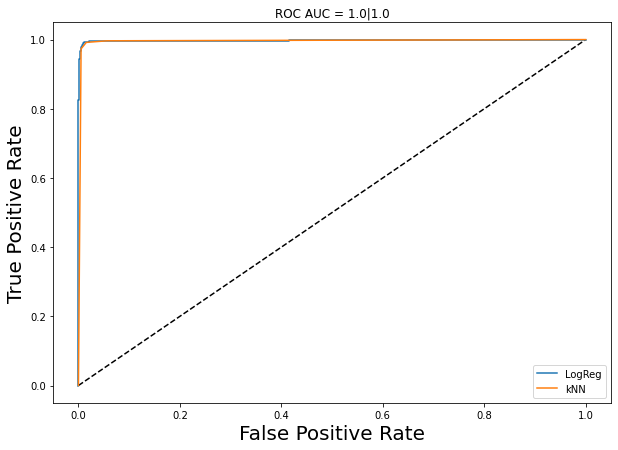

In [ ]:
# построим ROC-кривую
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, _ = roc_curve(y_test_body, y_pred_prob_test_LR)
fpr_knn, tpr_knn, _ = roc_curve(y_test_body, y_pred_prob_test_KNN)

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label="LogReg")
plt.plot(fpr_knn, tpr_knn, label="kNN")
plt.title(f'ROC AUC = {round(auc(fpr_lr, tpr_lr),2)}|{round(auc(fpr_knn, tpr_knn), 2)}')
plt.ylabel("True Positive Rate", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)
plt.legend()
plt.show()

### Задание 2: Определение класса

Теперь опробуем построить модель, которая будет предсказывать class физической формы.

Для этого определим метрики качества для задачи мультиклассификации (аргументируйте выбор).

Построем модель мультиклассовой классификации на основе линейного классификатора и сравним с KNN.

In [ ]:
df_body_class = pd.get_dummies(
    df_body,
    columns=['gender'],
    drop_first=True
)

df_body_class

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,gender_M
0,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C,1
1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A,1
2,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C,1
3,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B,1
4,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B,1
...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,C,1
13389,21.0,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,D,1
13390,39.0,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,A,1
13391,64.0,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,D,0


In [ ]:
X = df_body_class.drop(columns=["class"]) # укажите новый таргет
y = df_body_class["class"]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_2, y_train_2)

# .transform() на обучении и тесте (возвращает numpy, поэтому надо самим конвертировать обратно в dataframe с нужными индексами колонками)
X_train_2 = pd.DataFrame(scaler.transform(X_train_2), index=X_train_2.index, columns=X_train_2.columns)
X_test_2  = pd.DataFrame(scaler.transform(X_test_2), index=X_test_2.index, columns=X_test_2.columns)

**Логистическая регрессия:**

In [ ]:
# Обучим логистическую регрессию
model_LR_class = LogisticRegression()

# Обучим его на обучающем датасете
model_LR_class.fit(X_train_2, y_train_2)

# Получим предсказания
y_pred_test_body_LR_class = model_LR_class.predict(X_test_2)

y_pred_test_body_LR_class_proba = model_LR_class.predict_proba(X_test_2)

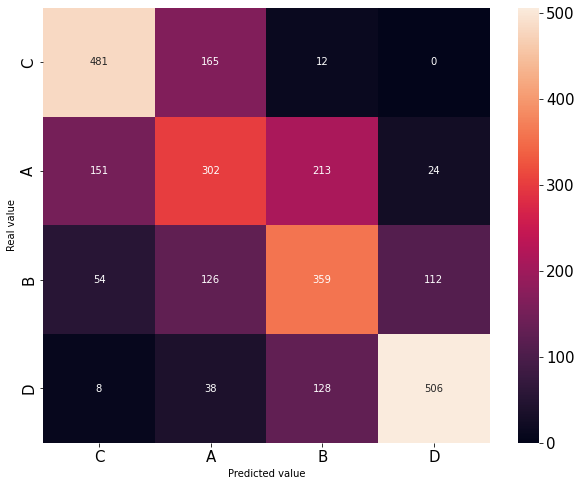

In [ ]:
# Построим матрицу ошибок, чтобы понять как справляется наш алгоритм
mp_mtx = confusion_matrix(y_test_2, y_pred_test_body_LR_class)

fig = plt.figure(figsize=(10,8))
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
sns.heatmap(mp_mtx, annot=True, fmt="d",
            xticklabels=df_body_class["class"].unique(),
            yticklabels=df_body_class["class"].unique())
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.show()

In [ ]:
# Рассчитаем micro average
print(f"MICRO PRECISION: {precision_score(y_test_2, y_pred_test_body_LR_class, average='micro')}")

MICRO PRECISION: 0.6151549085479656


In [ ]:
# Рассчитаем ROC-AUC разными стратегиями

print(f"OvO: {roc_auc_score(y_test_2, y_pred_test_body_LR_class_proba, multi_class='ovo')}")
print(f"OvR: {roc_auc_score(y_test_2, y_pred_test_body_LR_class_proba, multi_class='ovr')}")

OvO: 0.8509396347581104
OvR: 0.8508808003521855


**KNN-модель**

In [ ]:
# Создадим модель KNN
# Создадим объект класса KNeighborsClassifier
model_knn_class = KNeighborsClassifier()

# Обучим его на обучающем сете
model_knn_class.fit(X_train_2, y_train_2)

# Получим предсказания для обучающего и тестового датасета
y_pred_test_KNN_class  = model_knn_class.predict(X_test_2)
y_pred_test_KNN_class_proba  = model_knn_class.predict_proba(X_test_2)

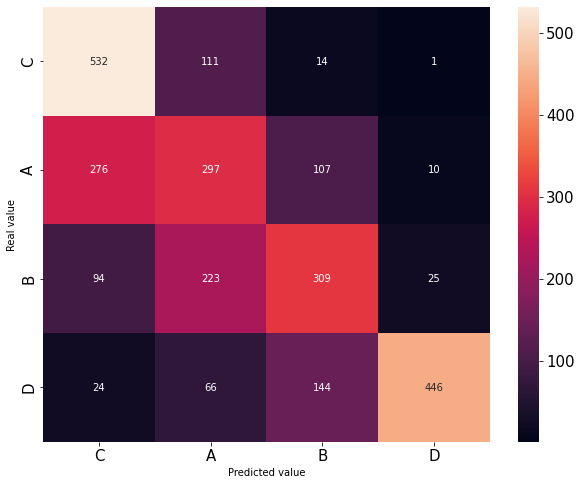

In [ ]:
# Построим матрицу ошибок, чтобы понять как справляется наш алгоритм
mp_mtx = confusion_matrix(y_test_2, y_pred_test_KNN_class)

fig = plt.figure(figsize=(10,8))
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
sns.heatmap(mp_mtx, annot=True, fmt="d",
            xticklabels=df_body_class["class"].unique(),
            yticklabels=df_body_class["class"].unique())
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.show()

In [ ]:
# Рассчитаем micro average
print(f"MICRO PRECISION: {precision_score(y_test_2, y_pred_test_KNN_class, average='micro')}")

MICRO PRECISION: 0.5912653975363942


In [ ]:
# Рассчитаем ROC-AUC разными стратегиями

print(f"OvO: {roc_auc_score(y_test_2, y_pred_test_KNN_class_proba, multi_class='ovo')}")
print(f"OvR: {roc_auc_score(y_test_2, y_pred_test_KNN_class_proba, multi_class='ovr')}")

OvO: 0.8193297652537751
OvR: 0.8193013739079136


**Модели с Label Encoding**

In [ ]:
#Label Encoding

le = preprocessing.LabelEncoder()
df_body_encoded = df_body.apply(le.fit_transform)
df_body_encoded

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,6,1,280,911,208,47,49,441,358,62,167,2
1,4,1,207,292,124,44,45,254,335,55,179,0
2,10,1,353,985,188,59,71,338,288,51,131,2
3,11,1,302,772,165,43,66,304,323,55,169,1
4,7,1,295,660,142,36,46,325,449,47,167,1
...,...,...,...,...,...,...,...,...,...,...,...,...
13388,4,1,278,798,131,41,60,248,347,49,148,2
13389,0,1,354,539,76,41,47,219,174,50,117,3
13390,18,1,329,1041,188,45,51,523,336,47,179,0
13391,43,0,23,357,447,34,40,80,256,0,26,3


In [ ]:
X = df_body_encoded.drop(columns=["class"]) # укажите новый таргет
y = df_body_encoded["class"]

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_3, y_train_3)

# .transform() на обучении и тесте (возвращает numpy, поэтому надо самим конвертировать обратно в dataframe с нужными индексами колонками)
X_train_3 = pd.DataFrame(scaler.transform(X_train_3), index=X_train_3.index, columns=X_train_3.columns)
X_test_3  = pd.DataFrame(scaler.transform(X_test_3), index=X_test_3.index, columns=X_test_3.columns)

In [ ]:
# Создадим модель KNN
# Создадим объект класса KNeighborsClassifier
model_knn_class_3 = KNeighborsClassifier()

# Обучим его на обучающем сете
model_knn_class_3.fit(X_train_3, y_train_3)

# Получим предсказания для обучающего и тестового датасета
y_pred_test_KNN_class_3  = model_knn_class_3.predict(X_test_3)
y_pred_test_KNN_class_3_proba  = model_knn_class_3.predict_proba(X_test_3)

In [ ]:
# Рассчитаем micro average
print(f"MICRO PRECISION: {precision_score(y_test_3, y_pred_test_KNN_class_3, average='micro')}")

MICRO PRECISION: 0.5908921239268383


In [ ]:
# Рассчитаем ROC-AUC разными стратегиями

print(f"OvO: {roc_auc_score(y_test_3, y_pred_test_KNN_class_3_proba, multi_class='ovo')}")
print(f"OvR: {roc_auc_score(y_test_3, y_pred_test_KNN_class_3_proba, multi_class='ovr')}")

OvO: 0.8170233370952086
OvR: 0.8170092139459635


In [ ]:
# Обучим логистическую регрессию
model_LR_class_3 = LogisticRegression()

# Обучим его на обучающем датасете
model_LR_class_3.fit(X_train_3, y_train_3)

# Получим предсказания
y_pred_test_body_LR_class_3 = model_LR_class_3.predict(X_test_3)

y_pred_test_body_LR_class_3_proba = model_LR_class_3.predict_proba(X_test_3)

In [ ]:
# Рассчитаем micro average
print(f"MICRO PRECISION: {precision_score(y_test_3, y_pred_test_body_LR_class_3, average='micro')}")

MICRO PRECISION: 0.6129152668906308


In [ ]:
# Рассчитаем ROC-AUC разными стратегиями

print(f"OvO: {roc_auc_score(y_test_3, y_pred_test_body_LR_class_3_proba, multi_class='ovo')}")
print(f"OvR: {roc_auc_score(y_test_3, y_pred_test_body_LR_class_3_proba, multi_class='ovr')}")

OvO: 0.8507563223831305
OvR: 0.8506887284767337
